# Bibliotecas

In [ ]:
# Instala bibliotecas no ambiente pelo pip
!pip install sidrapy
# Atenção! a biblioteca zetables tem apresentado problemas, portanto, não é recomendodado o seu uso.
# !pip install zentables

# Importa módulos/bibliotecas
import sidrapy as sidra
import pandas as pd
# import zentables as zen

# Dados

In [2]:
# Coleta de dados
dados_brutos = list(
    map(
        # função com 2 argumentos que será repetida
        lambda tabela, variavel: ( # lambda argumento1, argumento2: função/expressão a ser executada
            sidra.get_table(
                table_code = tabela,
                territorial_level = "1", # alguns argumentos recebem valores padrão
                ibge_territorial_code = "all",
                variable = variavel,
                classifications = { # PIB preços mercado e componentes (óticas)
                    "11255": "90687,90691,90696,90707,93404,93405,93406,93407,93408"
                    },
                period = "all"
                )
            ),

        # códigos das tabelas (pro argumento tabela)
        ["1620", "1621", "1846", "6612", "6613"],

        # códigos da variável dentro da tabela (pro argumento variavel)
        ["583", "584", "585", "9318", "9319"]
        )
    )
dados_brutos # lista de DataFrames

[                             NC                 NN  \
 0    Nível Territorial (Código)  Nível Territorial   
 1                             1             Brasil   
 2                             1             Brasil   
 3                             1             Brasil   
 4                             1             Brasil   
 ..                          ...                ...   
 995                           1             Brasil   
 996                           1             Brasil   
 997                           1             Brasil   
 998                           1             Brasil   
 999                           1             Brasil   
 
                              MC                 MN       V              D1C  \
 0    Unidade de Medida (Código)  Unidade de Medida   Valor  Brasil (Código)   
 1                            30      Número-índice  105.32                1   
 2                            30      Número-índice   93.19                1   
 3                

In [3]:
# Tratamento de dados
dados = (
    pd.concat(  # empilha em uma tabela todos os DataFrames
        objs = dados_brutos,
        keys = ["num_indice", "num_indice_sa", "precos_correntes",
                "precos_constantes", "precos_constantes_sa"],
        names = ["tabela", "linha"]
        )
    .reset_index()
    .rename(columns = dados_brutos[0].iloc[0])
    # filtra na coluna Trimestre tudo que não for igual a "Trimestre" (cabeçalho)
    .query("Trimestre not in 'Trimestre'")
    .rename(
        columns = {
            "Trimestre (Código)": "data",
            "Setores e subsetores": "rubrica",
            "Valor": "valor"
            }
            )
    .filter(items = ["tabela", "data", "rubrica", "valor"], axis = "columns")
    .replace( # recodifica valores da coluna rubrica
        to_replace = {
            "rubrica": {
                "Agropecuária - total": "Agropecuária",
                "Indústria - total": "Indústria",
                "Serviços - total": "Serviços",
                "PIB a preços de mercado": "PIB",
                "Despesa de consumo das famílias": "Consumo das Famílias",
                "Despesa de consumo da administração pública": "Despesa do Governo",
                "Formação bruta de capital fixo": "FBFC",
                "Exportação de bens e serviços": "Exportação",
                "Importação de bens e serviços (-)": "Importação"
                }
                }
             )
    .assign(  # substitui o 5º caracter da coluna data por "-Q" e converte em YYYY-MM-DD
        data = lambda x: pd.to_datetime(
            x.data.str.slice_replace(start = 4, stop = 5, repl = "-Q")
            ),
        valor = lambda x: x.valor.astype(float) # converte de texto para numérico
        )
    )
dados

,tabela,data,rubrica,valor
1,num_indice,1996-01-01,Agropecuária,105.32
2,num_indice,1996-01-01,Indústria,93.19
3,num_indice,1996-01-01,Serviços,98.31
4,num_indice,1996-01-01,PIB,96.84
5,num_indice,1996-01-01,Consumo das Famílias,96.06
...,...,...,...,...
4995,precos_constantes_sa,2023-07-01,Consumo das Famílias,220367.20
4996,precos_constantes_sa,2023-07-01,Despesa do Governo,57067.24
4997,precos_constantes_sa,2023-07-01,FBFC,57824.85
4998,precos_constantes_sa,2023-07-01,Exportação,49425.25


# Taxas de Variação

In [12]:
# Calculando taxas de variação com as fórmulas expostas
taxas = (
    dados.query("tabela in ['num_indice', 'num_indice_sa']")
    .pivot(index = ["data", "rubrica"], columns = "tabela", values = "valor")
    .reset_index()
    .sort_values("data") # ordena ascedentemente pela coluna data
    )
# cria novas colunas/cálculo por grupo (rubrica) feito dentro do apply()
taxas["var_margem"] = (
    taxas.groupby("rubrica", group_keys=False)["num_indice_sa"] # agrupa os dados e aponta a coluna
    .apply(lambda x: x.pct_change(1) * 100)   # calcula a variação na coluna
)
taxas["var_interanual"] = (
    taxas.groupby("rubrica", group_keys=False)["num_indice"]
    .apply(lambda x: x.pct_change(4) * 100)
)
taxas["var_anual"] = (
    taxas.groupby("rubrica", group_keys=False)["num_indice"] # soma móvel de 4 períodos
    .apply(lambda x: (x.rolling(4).sum() / x.rolling(4).sum().shift(4) - 1) * 100)
)
taxas["ano"] = taxas["data"].dt.year
taxas["num_indice_acum"] = (
    taxas.groupby(["rubrica", "ano"], group_keys=False)["num_indice"]
    .apply(lambda x: x.cumsum()) # acumula o número índice por ano/rubrica
    )
taxas["var_acum_ano"] = (
    taxas.groupby("rubrica", group_keys=False)["num_indice_acum"]
    .apply(lambda x: x.pct_change(4) * 100)
)
taxas

tabela,data,rubrica,num_indice,num_indice_sa,var_margem,var_interanual,var_anual,ano,num_indice_acum,var_acum_ano
0,1996-01-01,Agropecuária,105.32,95.19,NaN,NaN,NaN,1996,105.32,NaN
1,1996-01-01,Consumo das Famílias,96.06,97.82,NaN,NaN,NaN,1996,96.06,NaN
2,1996-01-01,Despesa do Governo,96.12,99.15,NaN,NaN,NaN,1996,96.12,NaN
3,1996-01-01,Exportação,95.16,99.22,NaN,NaN,NaN,1996,95.16,NaN
4,1996-01-01,FBFC,92.91,96.84,NaN,NaN,NaN,1996,92.91,NaN
...,...,...,...,...,...,...,...,...,...,...
993,2023-07-01,Exportação,382.40,371.95,2.953388,9.989358,10.272336,2023,1087.14,9.755580
994,2023-07-01,FBFC,166.92,161.50,-2.528819,-6.764229,-1.089432,2023,490.81,-2.531972
995,2023-07-01,Importação,268.48,258.98,-2.142452,-6.139002,-0.067141,2023,771.63,-1.289481
996,2023-07-01,Indústria,145.36,138.74,0.572671,0.965479,1.997406,2023,413.36,1.160002


# Visualização de dados

array([[<Axes: >, <Axes: >],
       [<Axes: >, <Axes: >]], dtype=object)

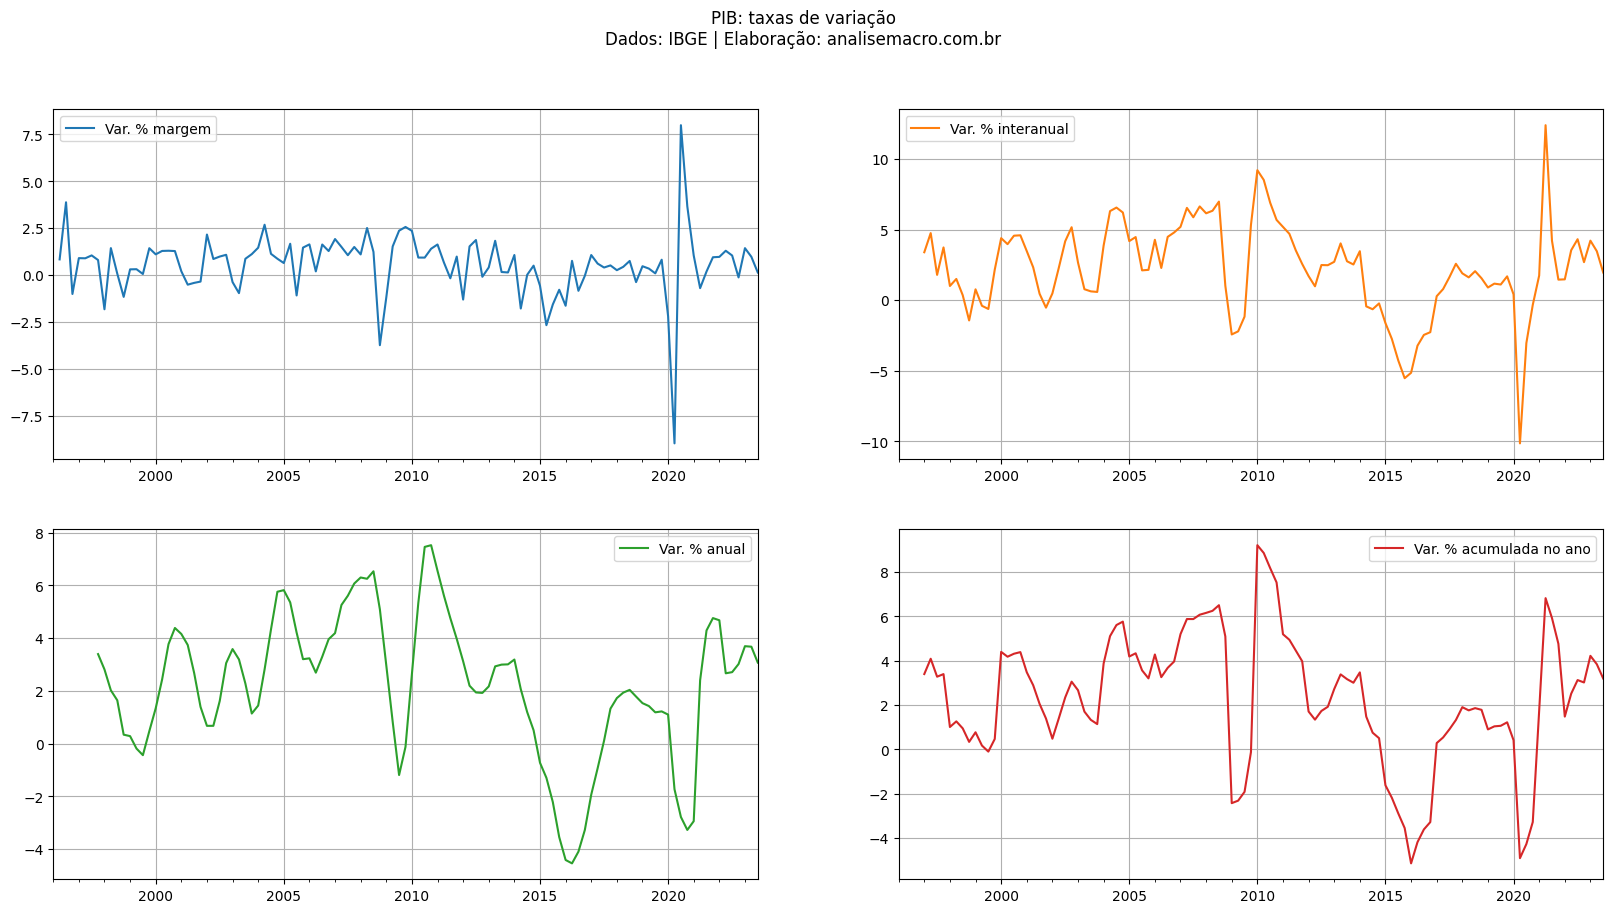

In [5]:
# Gráficos de linha do PIB
(
    taxas.query("rubrica == 'PIB'")
    .filter(
        items = ["data", "var_margem", "var_interanual", "var_anual", "var_acum_ano"],
        axis = "columns"
        )
    .rename(columns = {
        "var_margem": "Var. % margem",
        "var_interanual": "Var. % interanual",
         "var_anual": "Var. % anual",
         "var_acum_ano": "Var. % acumulada no ano"
         }
         )
    .set_index("data") # torna a coluna como índice da tabela
    .plot(             # cria o gráfico com as definições abaixo
        xlabel = "",
        ylabel = "",
        subplots = True,
        layout = (2, 2),
        figsize = (20, 10),
        sharex = False,
        grid = True,
        title = "PIB: taxas de variação\nDados: IBGE | Elaboração: analisemacro.com.br"
        )
    )

In [6]:
# Tabela dos componentes do PIB (óticas)
taxas_final = (
    taxas.query("data == data.max()")
    .filter(
        items = ["rubrica", "var_margem", "var_interanual", "var_anual", "var_acum_ano"],
        axis = "columns"
        )
    .rename(columns = {
        "var_margem": "Var. % margem",
        "var_interanual": "Var. % interanual",
         "var_anual": "Var. % anual",
         "var_acum_ano": "Var. % acumulada no ano"
         }
         )
    .set_index("rubrica")
    )
taxas_final

tabela,Var. % margem,Var. % interanual,Var. % anual,Var. % acumulada no ano
rubrica,,,,
PIB,0.146699,1.961320,3.072792,3.195637
Agropecuária,-3.347900,8.770846,14.387587,18.143909
Consumo das Famílias,1.093516,3.266674,3.719230,3.421190
Despesa do Governo,0.540118,0.770127,0.965124,1.208426
Exportação,2.953388,9.989358,10.272336,9.755580
FBFC,-2.528819,-6.764229,-1.089432,-2.531972
Importação,-2.142452,-6.139002,-0.067141,-1.289481
Indústria,0.572671,0.965479,1.997406,1.160002
Serviços,0.603036,1.794818,2.826043,2.572388


In [ ]:
# taxas_final.zen.pretty(font_size = 12).format(precision = 2)

# Deflator do PIB

In [8]:
# Calculando o deflator
deflator = (
    dados.query(
        "tabela in ['precos_correntes', 'precos_constantes'] and rubrica == 'PIB'"
        )
    .pivot(
        index = "data",
        columns = "tabela",
        values = "valor"
        )
    .assign(
        deflator = lambda x: x.precos_correntes / x.precos_constantes * 100,
        var_anual = lambda x: (
            x.deflator.rolling(4).sum() / x.deflator.shift(4).rolling(4).sum() - 1
            ) * 100
        )
    )
deflator

tabela,precos_constantes,precos_correntes,deflator,var_anual
data,,,,
1996-01-01,170920.00,189323.0,110.767026,NaN
1996-04-01,176708.75,204611.0,115.789965,NaN
1996-07-01,189844.26,221513.0,116.681431,NaN
1996-10-01,184112.94,239316.0,129.983259,NaN
1997-01-01,176732.25,219117.0,123.982465,NaN
...,...,...,...,...
2022-07-01,323064.76,2601182.0,805.158074,9.375147
2022-10-01,315307.04,2641485.0,837.750086,8.545278
2023-01-01,318315.84,2582706.0,811.365843,8.723255


<Axes: xlabel='data'>

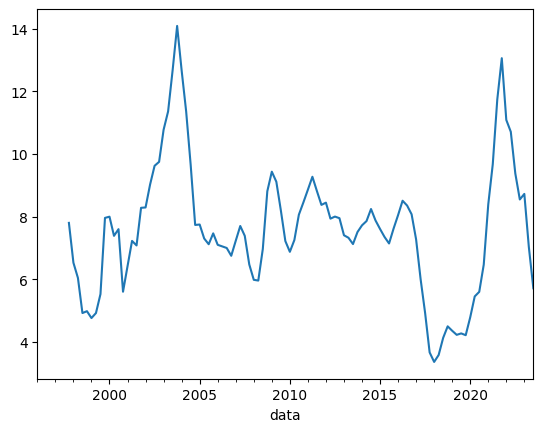

In [9]:
# Gráfico de linha da variação anual do deflator
deflator.var_anual.plot()

# Carrego Estatístico

In [10]:
# Decomposição do PIB: carrego e crescimento no ano
decomposicao = (
    dados.query("rubrica == 'PIB' and tabela == 'precos_constantes_sa'")
    .assign(
        A = lambda x: x.valor.rolling(4).mean().shift(4),
        B = lambda x: x.valor.shift(4),
        C = lambda x: x.valor.rolling(4).mean(),
        carrego = lambda x: (x.B - x.A) / x.A * 100,
        cres_ano = lambda x: (x.C - x.B) / x.A * 100,
        total = lambda x: x.carrego + x.cres_ano
        )
    .query("data.dt.quarter == 4")
    .assign(ano = lambda x: x.data.dt.year)
    .filter(items = ["ano", "carrego", "cres_ano", "total"])
    .rename(columns = {
        "carrego": "Carrego Estatístico",
        "cres_ano": "Crescimento no Ano",
        "total": "Crescimento Anual"
        }
        )
    )
decomposicao

,ano,Carrego Estatístico,Crescimento no Ano,Crescimento Anual
4031,1996,NaN,NaN,NaN
4067,1997,1.359150,2.366814,3.725965
4103,1998,1.359028,-1.006348,0.352680
4139,1999,-0.467783,0.943519,0.475736
4175,2000,1.193436,3.128056,4.321492
4211,2001,1.932713,-0.460230,1.472483
4247,2002,-0.583973,3.604237,3.020263
4283,2003,1.526817,-0.365541,1.161276
4319,2004,1.038474,4.375986,5.414460
4355,2005,1.889317,1.769473,3.658790


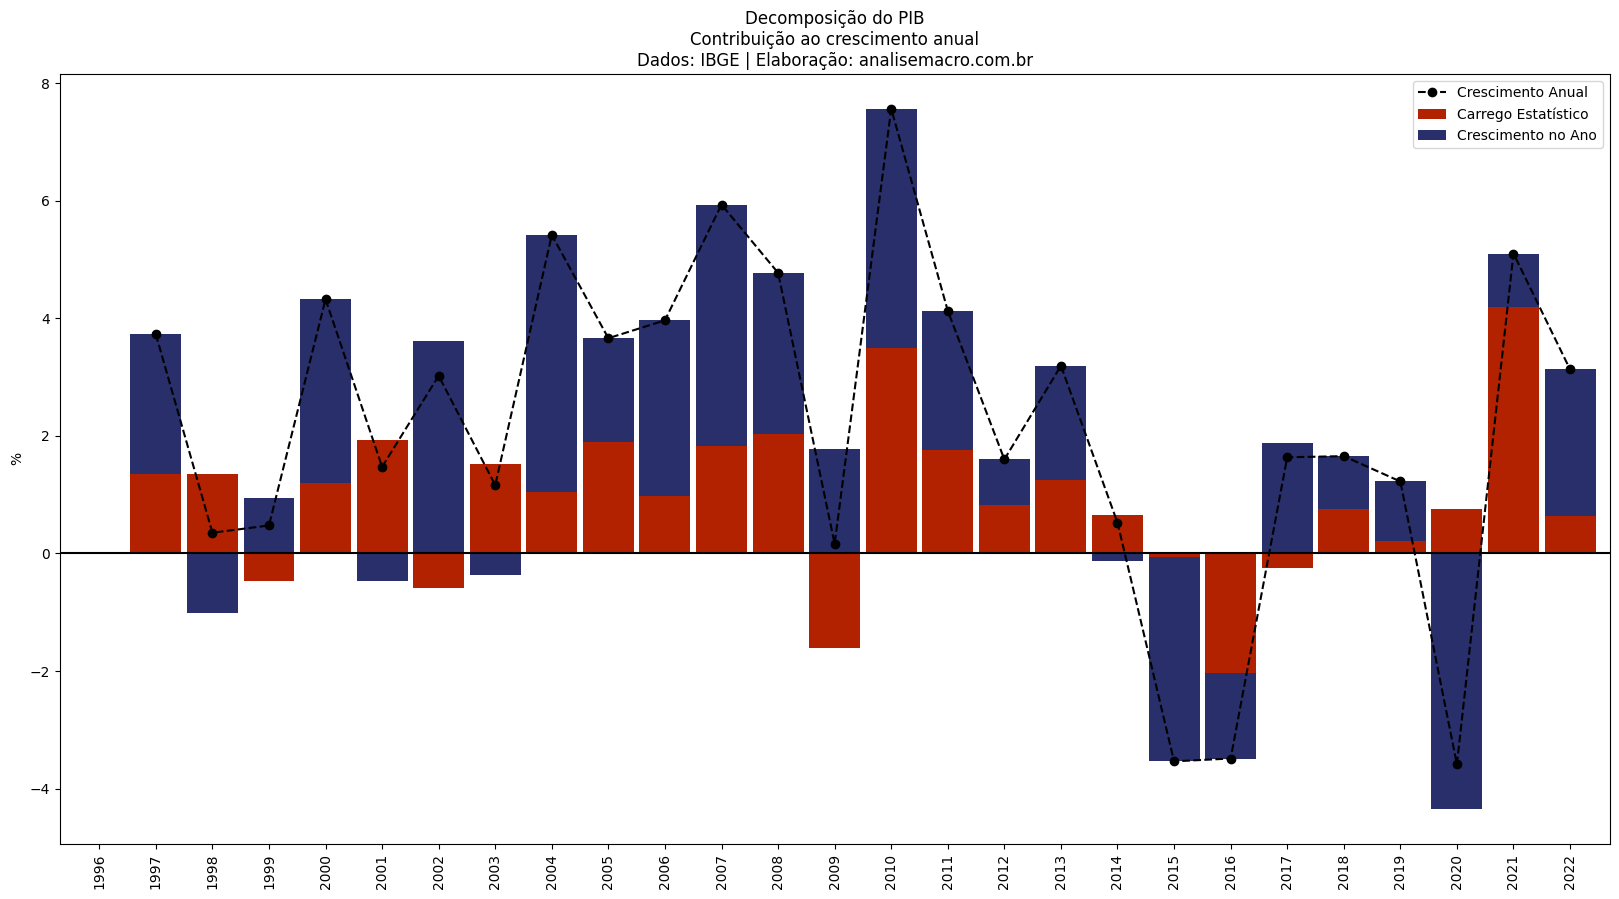

In [11]:
# Visualiza a decomposição do PIB (colunas+linha)
grafico = decomposicao[["ano", "Crescimento Anual"]].plot( # gráfico de linha
    x = "ano",
    linestyle = "dashed",
    marker = "o",
    color = {"Crescimento Anual": "black"},
    use_index = False
    )
grafico = decomposicao[["ano", "Carrego Estatístico", "Crescimento no Ano"]].plot( # coluna
    x = "ano",
    kind = "bar",
    stacked = True,
    ax = grafico, # "adiciona" os dois em um mesmo gráfico
    width = 0.9,
    figsize = (20, 10),
    color = {"Carrego Estatístico": "#b22200", "Crescimento no Ano": "#282f6b"},
    ylabel = "%",
    xlabel = "",
    title = "Decomposição do PIB\nContribuição ao crescimento anual\nDados:" +
    " IBGE | Elaboração: analisemacro.com.br"
    )
grafico.axhline(y = 0, color = "black") # linha horizontal